## Introduction

MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike. In this notebook, our goal is to correctly identify digits from a dataset of tens of thousands of handwritten images. 

In [1]:
#importing libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
print(train_data.shape)
print(test_data.shape)

(42000, 785)
(28000, 784)


## Preparing Data

In [4]:
Y_train = train_data['label']
X_train = train_data.drop(labels = ["label"],axis = 1) 

# free some space
del train_data

In [5]:
#data quality & missing value check
#number of unique value
Y_train.nunique() # 0-9 digits
#null value check
X_train.isnull().any().describe()
test_data.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [6]:
#normalize
X_train = np.array(X_train, dtype=np.float64)
test_data = np.array(test_data, dtype=np.float64)
X_train /= 255
test_data /= 255

In [7]:
#reshaping
X_train = X_train.reshape(-1,28,28,1)
test_data = test_data.reshape(-1,28,28,1)

In [8]:
#label encoding (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
Y_train = to_categorical(Y_train, num_classes = 10)

In [9]:
# Set the random seed
random_seed = 2

In [10]:
#splitting data
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

## Building and Compiling Model

In [12]:
import tensorflow
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [15]:
#Define the optimizer
from keras.optimizers import RMSprop
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [16]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [18]:
# Set a learning rate annealer
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [19]:
epochs = 10
batch_size = 86

In [23]:
#Data augmentation
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [24]:
#fit model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/10


/var/folders/p9/1cnldwg52d39t1tmjhv1ml5r0000gn/T/ipykernel_39419/2148786107.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
2023-01-11 00:59:43.557110: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


439/439 - 40s - loss: 0.4117 - accuracy: 0.8661 - val_loss: 0.0669 - val_accuracy: 0.9805 - lr: 0.0010 - 40s/epoch - 91ms/step
Epoch 2/10
439/439 - 42s - loss: 0.1340 - accuracy: 0.9592 - val_loss: 0.0527 - val_accuracy: 0.9840 - lr: 0.0010 - 42s/epoch - 95ms/step
Epoch 3/10
439/439 - 42s - loss: 0.0977 - accuracy: 0.9708 - val_loss: 0.0314 - val_accuracy: 0.9900 - lr: 0.0010 - 42s/epoch - 96ms/step
Epoch 4/10
439/439 - 43s - loss: 0.0823 - accuracy: 0.9761 - val_loss: 0.0518 - val_accuracy: 0.9869 - lr: 0.0010 - 43s/epoch - 97ms/step
Epoch 5/10
439/439 - 44s - loss: 0.0756 - accuracy: 0.9772 - val_loss: 0.0318 - val_accuracy: 0.9905 - lr: 0.0010 - 44s/epoch - 99ms/step
Epoch 6/10
439/439 - 43s - loss: 0.0704 - accuracy: 0.9800 - val_loss: 0.0303 - val_accuracy: 0.9912 - lr: 0.0010 - 43s/epoch - 99ms/step
Epoch 7/10
439/439 - 43s - loss: 0.0646 - accuracy: 0.9805 - val_loss: 0.0267 - val_accuracy: 0.9921 - lr: 0.0010 - 43s/epoch - 98ms/step
Epoch 8/10
439/439 - 45s - loss: 0.0604 - acc

## Validation

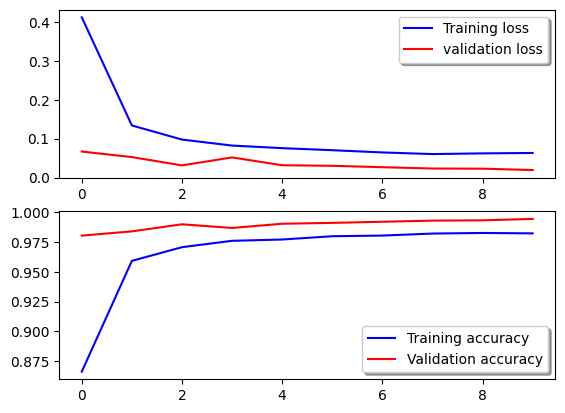

In [26]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## Prediction

In [29]:
# predict results
results = model.predict(test_data)

# select maximum probability
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")

# for submission

submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("submission.csv",index=False)

875/875 [==============================] - 8s 9ms/step
